# Bay Area Bike Share - Python Analysis

### Introduction
Bay Area Bike Share is the region’s bike sharing system with 700 bikes and 61 stations across the region, with different locations in California. It is a company that provides Bay Area residents and visitors with an additional transportation option for getting around the region. 
Users have the access to pick up and drop the bike from and to any station irrespective of where it was picked from. There are two ways in which users pay for this service. 
1.	By getting a yearly subscription – Subscribers 
2.	By purchasing a 3-day or 24-hours pass – Customers 
There is an overtime fee charge if the trip length exceeds thirty minutes with an option to make unlimited number of trips under thirty minutes.

### Dataset

The data set contains the bike data from the year 2015-2016.
It contains 3 different csv's that has been used in the analysis:
1. 201608_station_data.csv - Basic information about station locations and capacities.
2. 201608_trip_data.csv - Information about each trip taken using the bike share system.
3. 201608_weather_data.csv - Weather information by day for one station in each city in the bike share program.


In [158]:
#Importing all the necessary libraries required for the analysis
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import sqlite3 as lite
from datetime import datetime
import seaborn as sns
%matplotlib inline

In [159]:
#Creating a function to replace camelcase with underscore
def clean_camelcase(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1)

In [160]:
#Creating a function to replace the empty space in column names 
def clean_colheaders(df):
    
    df_columns = []
    for name in df.columns.tolist():
        df_columns.append(name.lstrip())
        
    df.columns = [name.rstrip() for name in df.columns.tolist()]
    df.columns = [name.replace(' ','') for name in df.columns.tolist()]    
    df.columns = [name.replace('_','') for name in df.columns.tolist()]    
    df.columns = [clean_camelcase(name) for name in df.columns.tolist()]
    return df

In [161]:
#Creating data frames to read different input files
df_weather = pd.read_csv("201608_weather_data.csv", nrows=None)
df_station = pd.read_csv("201608_station_data.csv", nrows=None)
df_trip = pd.read_csv("201608_trip_data.csv", nrows=None)

### Data Cleansing

In [162]:
#Cleaning column names
dfs = [df_weather,df_station,df_trip]
for idx,df in enumerate(dfs):
    dfs[idx] = clean_colheaders(dfs[idx])

In [163]:
#Checking if the column names got changed properly
df_trip.head()

,Trip_ID,Duration,Start_Date,Start_Station,Start_Terminal,End_Date,End_Station,End_Terminal,Bike#,Subscriber_Type,Zip_Code
0,913465,746,9/1/2015 0:10,San Francisco Caltrain 2 (330 Townsend),69,9/1/2015 0:23,San Francisco City Hall,58,238,Subscriber,94107
1,913466,969,9/1/2015 0:15,Clay at Battery,41,9/1/2015 0:31,Washington at Kearny,46,16,Subscriber,94133
2,913467,233,9/1/2015 0:15,Davis at Jackson,42,9/1/2015 0:19,Commercial at Montgomery,45,534,Subscriber,94111
3,913468,213,9/1/2015 1:29,Clay at Battery,41,9/1/2015 1:32,Steuart at Market,74,312,Subscriber,94107
4,913469,574,9/1/2015 1:33,Steuart at Market,74,9/1/2015 1:42,San Francisco Caltrain 2 (330 Townsend),69,279,Subscriber,94107


In [164]:
#Renaming columns in the dataframe for better understanding
df_trip = df_trip.rename(columns = {"Subscriber_Type": "Subscription_Type"})
df_weather = df_weather.rename(columns = {'ZIP' : 'Pincode'})
df_trip = df_trip.rename(columns = {'Bike#' : 'BikeNumber'})
df_weather = df_weather.rename(columns = {'PDT' : 'Date'})

In [165]:
#Checking the table
df_trip.head()

,Trip_ID,Duration,Start_Date,Start_Station,Start_Terminal,End_Date,End_Station,End_Terminal,BikeNumber,Subscription_Type,Zip_Code
0,913465,746,9/1/2015 0:10,San Francisco Caltrain 2 (330 Townsend),69,9/1/2015 0:23,San Francisco City Hall,58,238,Subscriber,94107
1,913466,969,9/1/2015 0:15,Clay at Battery,41,9/1/2015 0:31,Washington at Kearny,46,16,Subscriber,94133
2,913467,233,9/1/2015 0:15,Davis at Jackson,42,9/1/2015 0:19,Commercial at Montgomery,45,534,Subscriber,94111
3,913468,213,9/1/2015 1:29,Clay at Battery,41,9/1/2015 1:32,Steuart at Market,74,312,Subscriber,94107
4,913469,574,9/1/2015 1:33,Steuart at Market,74,9/1/2015 1:42,San Francisco Caltrain 2 (330 Townsend),69,279,Subscriber,94107


In [166]:
# Removing the  outliers with values greater than 99.5th percentile
deviation = np.percentile(df_trip['Duration'],99.5)
df_trip = df_trip[df_trip['Duration'] <= deviation]

In [167]:
#Extracting the hour from the start date
df_trip['Depart_hour'] = df_trip['Start_Date'].map(lambda x:(datetime.strptime(x, "%m/%d/%Y %H:%M")).hour)

In [168]:
#Extracting the month from the start date
df_trip['Depart_month'] = df_trip['Start_Date'].map(lambda x:(datetime.strptime(x, "%m/%d/%Y %H:%M")).month)

In [169]:
#Extracting the day from the start date
df_trip['Depart_day'] = df_trip['Start_Date'].map(lambda x:(datetime.strptime(x, "%m/%d/%Y %H:%M")).day)

#### Creating SQL database and loading data to tables from csv files

In [170]:
# Creating a function to create SQL table
def create_table(df,table_name,con):
    df.to_sql(table_name,con,if_exists='replace')
    return 1

In [171]:
# Writing data from the dataframe to the sql
table_names = ["weather_detail","station_detail","trip_detail"]
dfs = [df_weather,df_station,df_trip,]
con = lite.connect("sfo_bike_latest_new.db")    
#Iterating over ds index    
for idx,df in enumerate(dfs):
    create_table(df,table_names[idx],con)

In [172]:
read_from_sql = True

In [173]:
df_trip.head()

,Trip_ID,Duration,Start_Date,Start_Station,Start_Terminal,End_Date,End_Station,End_Terminal,BikeNumber,Subscription_Type,Zip_Code,Depart_hour,Depart_month,Depart_day
0,913465,746,9/1/2015 0:10,San Francisco Caltrain 2 (330 Townsend),69,9/1/2015 0:23,San Francisco City Hall,58,238,Subscriber,94107,0,9,1
1,913466,969,9/1/2015 0:15,Clay at Battery,41,9/1/2015 0:31,Washington at Kearny,46,16,Subscriber,94133,0,9,1
2,913467,233,9/1/2015 0:15,Davis at Jackson,42,9/1/2015 0:19,Commercial at Montgomery,45,534,Subscriber,94111,0,9,1
3,913468,213,9/1/2015 1:29,Clay at Battery,41,9/1/2015 1:32,Steuart at Market,74,312,Subscriber,94107,1,9,1
4,913469,574,9/1/2015 1:33,Steuart at Market,74,9/1/2015 1:42,San Francisco Caltrain 2 (330 Townsend),69,279,Subscriber,94107,1,9,1


In [224]:
# Writing selected columns from the dataframe to sql
if read_from_sql == True:
    con = lite.connect("sfo_bike_latest_new.db")

    query_weat  = '''
            SELECT stationid , bikesavailable , docksavailable, time
            FROM weather_detail
            '''
    query_stn = '''
            SELECT stationid , lat , long , dockcount, landmark
            FROM station_detail;
            '''
    query_trip = '''
            SELECT Trip_ID , Duration , Start_Terminal,Start_Station, Start_Date, 
                   End_Terminal , End_Station, Subscription_Type , 
                   Zip_Code , Depart_day , Depart_month , Depart_hour
            FROM trip_detail;
            '''
    

    df_station = pd.read_sql_query(query_stn, con, index_col=None, coerce_float=True, \
                           params=None, parse_dates=None, chunksize=None)
    
    
    df_trip = pd.read_sql_query(query_trip, con, index_col=None, coerce_float=True, \
                           params=None, parse_dates=None, chunksize=None)
else:
    
    # Else only a subsets of the data frame is enough for the analysis
    df_trip = df_trip[['Trip_ID','Duration','Start_Terminal','End_Terminal','End_Station','Subscription_Type','Zip_Code','Depart_day','Depart_month','Depart_hour']]
    df_station = df_station[['station_id','lat','long','dockcount']]

In [225]:
#Extracting the day and month from the weather data frame
df_weather['Day'] = df_weather['Date'].map(lambda x:(datetime.strptime(x, "%m/%d/%Y")).day)
df_weather['Day'] = df_weather['Date'].map(lambda x:(datetime.strptime(x, "%m/%d/%Y")).month)

In [226]:
#Extracting the Week days from the trip dataset
df_trip['WeekDays'] = df_trip['Start_Date'].map(lambda x:(datetime.strptime(x, "%m/%d/%Y %H:%M")).weekday())

In [227]:
#Creating a function to calculate distance between stations based on latitude,longitude provided by the GPS.
#Formula used is called Haversine formula
def get_distance(lat1, lon1, lat2, lon2):

    lon1 = lon1*np.pi/180
    lon2 = lon2*np.pi/180
    lat2 = lat2*np.pi/180
    lat1 = lat1*np.pi/180

    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    
    R = 3961 # miles
    a = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2 
    c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) ) 
    d = R * c
    return d


df_trip = pd.merge(df_trip.rename(columns = {'Start_Terminal': 'stationid'}),
                   df_station[['lat','long','stationid']], \
                   how = 'left', on=['stationid'])
df_trip = df_trip.drop_duplicates()


df_trip = pd.merge(df_trip.rename(columns = {'lat':'Start_lat','long' : 'Start_long','stationid': 'Start_Terminal',
                                   'End_Terminal': 'stationid'})
                   ,df_station[['lat','long','stationid']], \
                    how = 'left', on=['stationid'])
df_trip = df_trip.drop_duplicates()

df_trip = df_trip.rename(columns = {'stationid': 'End_Terminal','lat':'End_lat','long' : 'End_long'})

df_trip['Distance'] = get_distance(df_trip['Start_lat'], df_trip['Start_long'], df_trip['End_lat'],
                                           df_trip['End_long'])

In [228]:
# Defining a color pattern based on Tableau's color code
colorcode = [(31, 119, 180), (255, 127, 14),\
             (44, 160, 44), (214, 39, 40), \
             (148, 103, 189),  (140, 86, 75), \
             (227, 119, 194), (127, 127, 127), \
             (188, 189, 34), (23, 190, 207)]

for i in range(len(colorcode)):  
    r, g, b = colorcode[i]  
    colorcode[i] = (r / 255., g / 255., b / 255.)

In [ ]:
df_trip.to_csv('df_trip.csv')
df_weather.to_csv('df_weather.csv')
df_station.to_csv('df_station.csv')

# Data Exploration

## Analysis 1

In [229]:
#1. Distribution of cities in the Bay Area

In [230]:
# Define a function to filter data to draw the plots with the filters like >,<,= and so on.
# Strip the quotes if it is a string and also convert value into number 
# only booleans for filtering
def refine_data(data, condition):

    
    field, op, value = condition.split(" ", 2)

    try:
        value = float(value)
    except:
        value = value.strip("\'\"")
    
    if op == ">":
        matches = data[field] > value
    elif op == "<":
        matches = data[field] != value
    else: # catch invalid operation codes
        raise Exception("Invalid comparison operator. Only >, <, >=, <=, ==, != allowed.")
    
    # filter data and outcomes
    data = data[matches].reset_index(drop = True)
    return data

In [231]:
def data_plot(data, key = '', filters = [], **kwargs):
    
    # Apply filters to data
    for condition in filters:
        data = refine_data(data, condition)

    # Create plotting figure
    plt.figure(figsize=(10,10))

    if isinstance(data[key][0] , str): 
        data['count'] = 1
        data = data.groupby(key, as_index = False).count()
        
        levels = data[key].unique()
        n_levels = len(levels)
        bar_width = 0.8
        
        for i in range(n_levels):
            trips_bar = plt.bar(i - bar_width/2, data.loc[i]['count'], width = bar_width)
        
        plt.xticks(range(n_levels), levels)
        
    else:
        if kwargs and 'n_bins' in kwargs and 'bin_width' in kwargs:
            raise Exception("Arguments 'n_bins' and 'bin_width' cannot be used simultaneously.")

        min_value = data[key].min()
        max_value = data[key].max()
        value_range = max_value - min_value
        n_bins = 100
        bin_width = float(value_range) / n_bins

        bins = [i*bin_width + min_value for i in range(n_bins+1)]
        
        
        plt.hist(data[key], bins = bins)

    # Common attributes for plot formatting
    key_name = ' '.join([x.capitalize() for x in key.split('_')])
    plt.xlabel(key_name)
    plt.ylabel("Number of Trips")
    plt.title("Number of Trips by {:s}".format(key_name))
    plt.show()

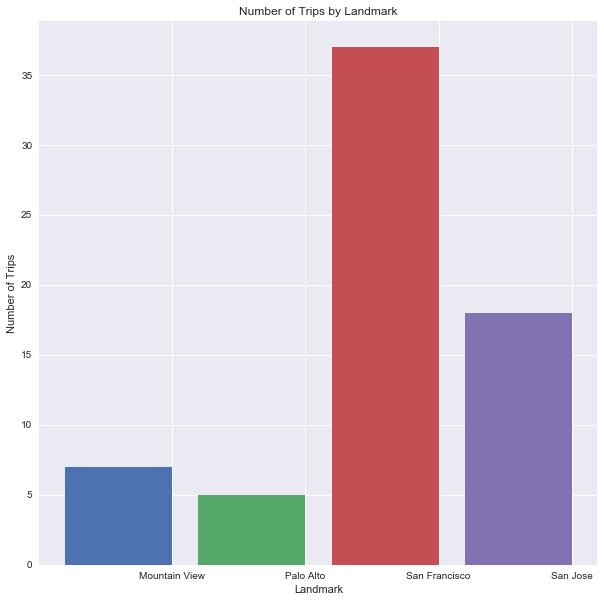

In [143]:
#Plot to check the most common landmarks from the list of stations
data_plot(df_station, 'landmark')

From the landmark plot it can be seen that the top stations are Mountain View, Palo Alto, San Fransisco and San Jose. It can also be analyzed that San Fransisco gets the highest number of trips followed by San Jose being the half of SF and Mountain View and Palo Alto the other halfs of San Jose.

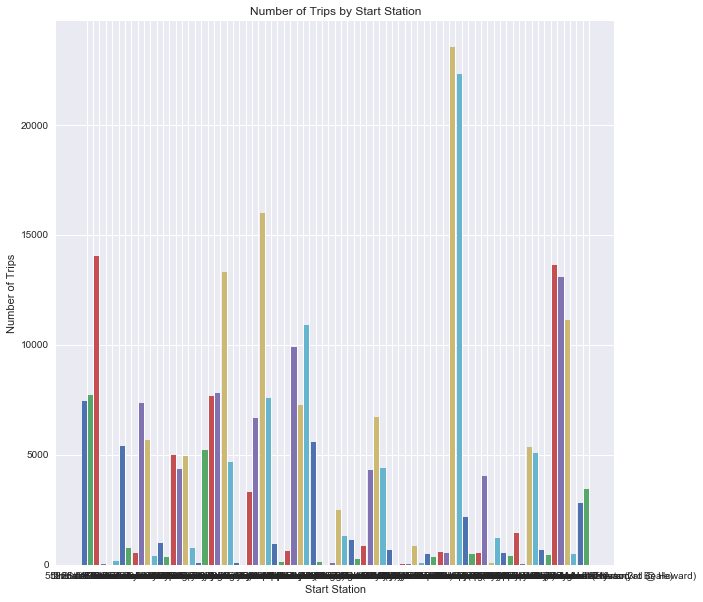

In [144]:
data_plot(df_trip, 'Start_Station')

From the list of 91 stations, it can be seen which station has most of the trips starting from there. It can be analyzed that the stations in SF region is ranked as the highest start station.
And the total number of trips started from SF over the year is in between 25000 - 20000.

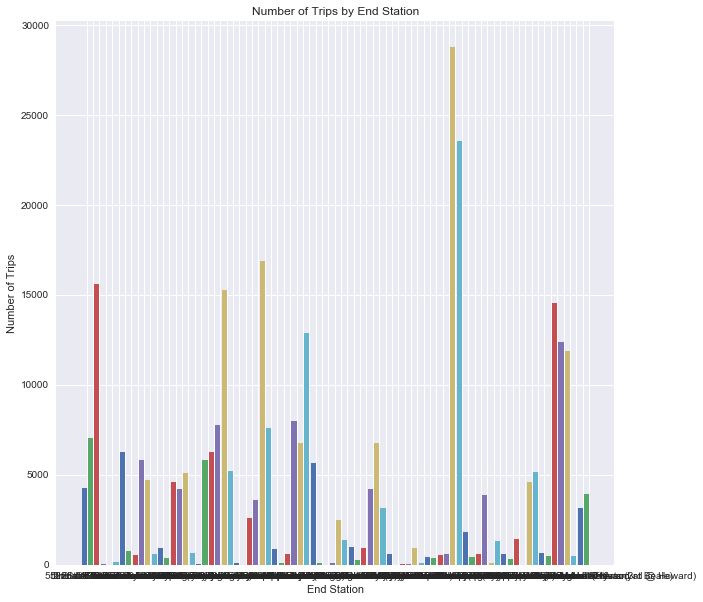

In [145]:
data_plot(df_trip, 'End_Station')

Again, from the list of 61 stations, it can be noticed that SF is the End Stations for most of the trips. And the total number of trips ended at SF over the year is closer to 30000 which more than the start stations.

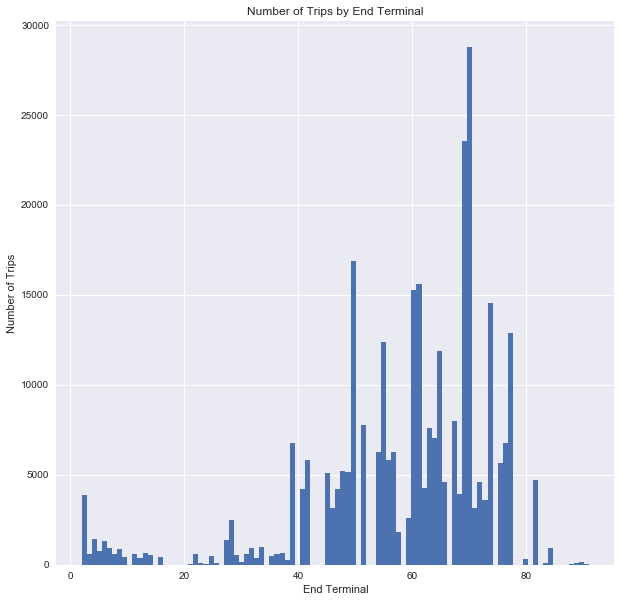

In [146]:
data_plot(df_trip, 'End_Terminal')

To confirm that the plot with the end terminal matches the plot with the en stations.

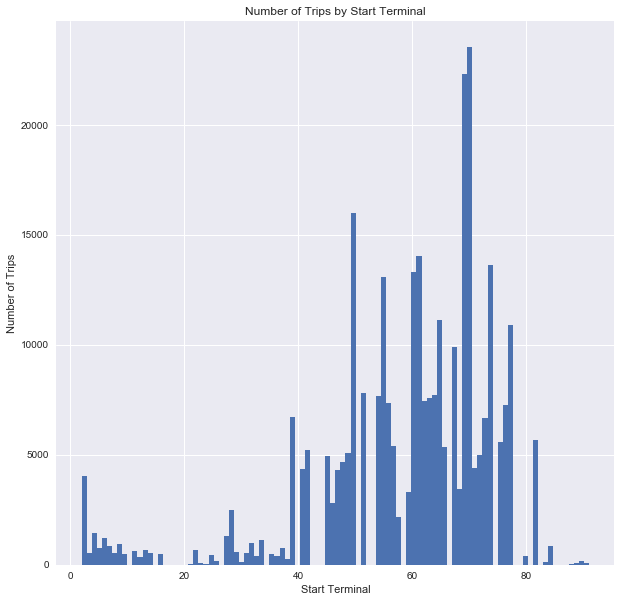

In [147]:
data_plot(df_trip, 'Start_Terminal')

To confirm that the plot with the start terminal matches the plot with the start stations.

#### Conclusion
From the first analysis there are certain things that can be concluded which is
1. San Fransisco is the Top Station in the Bay Area.
2. San Fransisco has most of the rides starting from their station.
3. San Fransisco has even more ride ending at their station.
4. Also, per year around 25000 bikes start from SF and 28000 bikes come back to SF station

It can be infered that more number of bikes should always be presnt in SF area as that has the highest traveling rate and would always be requiring more number of bikes when compared to the other stations.


# Analysis 2

In [116]:
#Interaction between all the stations in the bay area using the Haversine Formula defined above

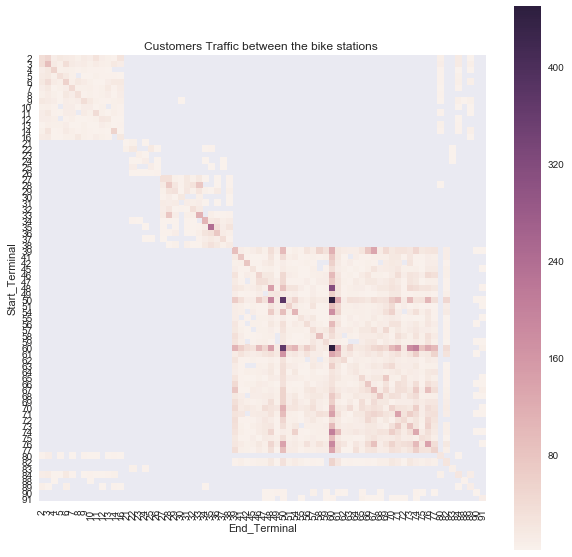

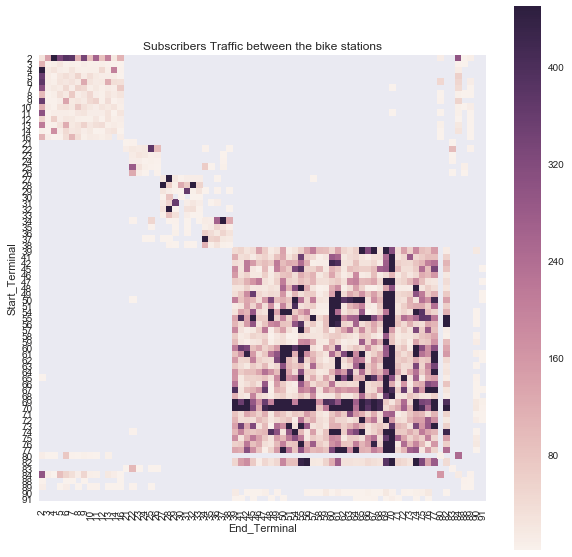

In [101]:
# Examining traffic between all the stations

endStationCountCust  = df_trip[df_trip['Subscription_Type'] == 'Customer'].groupby(['Start_Terminal','End_Terminal'])['Trip_ID'].count().unstack()
plt.figure(figsize = (10,10))
h = sns.heatmap(endStationCountCust ,linewidths=0, square=True , vmax=450)
h = plt.xticks(rotation='vertical')
h= plt.yticks(rotation='horizontal')
plt.title('Customers Traffic between the bike stations ')
plt.savefig('StationUsage_customers.png')

endStationCountSub  = df_trip[df_trip['Subscription_Type'] == 'Subscriber'].groupby(['Start_Terminal','End_Terminal'])['Trip_ID'].count().unstack()
plt.figure(figsize = (10,10))
h = sns.heatmap(endStationCountSub ,linewidths=0, square=True , vmax=450)
h = plt.xticks(rotation='vertical')
h= plt.yticks(rotation='horizontal')
plt.title('Subscribers Traffic between the bike stations')
plt.savefig('StationUsage_subscribers.png')

Created a Heat Map to get the number of rides determination between all the stations for both the Subscribers and the Customers.
From the heat map it can be seen that station terminal from 40 -90 is all having heavy traffic between stationa and this also confirm the heavy traffic in SF. The heat map also shows the relation between one station to another and the relations between stations.
For customers heat map it is seen that there is not much of traffic for customers as they would be the travelers who are visiting bay area and prefer takin smaller stops.

### Conclusion
It can be concluded that 
1. The distribution of traffic is different for customers and subscribers.
2. A fewer stations have a huge percentage of traffic compared to the other stations. 


# Analysis 3

In [197]:
#Defined a function to get the number of trips and the average drip duration made by the data points.
def usage_stats(data, filters = [], verbose = True):
    
    n_data_all = data.shape[0]

# Applying filters to the data
    for condition in filters:
        data = refine_data(data, condition)

# Calculate the number of data points that meet the filter condition.
    n_data = data.shape[0]
    
# If verbosity is set to true the Report computed statistics.
    if verbose:
        if filters:
            print('There are {:d} total number of trips ({:.2f}%) which matches the filter condition.'.format(n_data, 100. * n_data / n_data_all))
        else:
            print('There are {:d} total number of trips in the dataset.'.format(n_data))
# Computing the statistics for all the trip durations.
        print('The average duration of trips is {:.2f} minutes.'.format(data['Duration'].mean()))
        print('The median trip duration is {:.2f} minutes.'.format(data['Duration'].quantile([.25, .5, .75]).as_matrix()[1]))
        print('25% of trips are shorter than {:.2f} minutes.'.format(data['Duration'].quantile([.25, .5, .75]).as_matrix()[0]))
        print('25% of trips are longer than {:.2f} minutes.'.format(data['Duration'].quantile([.25, .5, .75]).as_matrix()[2]))

    #return duration_qtiles

Calculating the total trips made in the whole dataset using the usage_stats() function. Also, analyzed the statistics in respect to how the trip looked like in the over all sense. 

In [192]:
usage_stats(df_trip)

There are 312121 total number of trips in the dataset.
The average duration of trips is 698.95 minutes.
The median trip duration is 518.00 minutes.
25% of trips are shorter than 353.00 minutes.
25% of trips are longer than 731.00 minutes.


array([ 353.,  518.,  731.])

It can be noted that there were 312121 trips made in the year 2015-2016 in the Bay Area. Also it is surprising to note that the average trip duration is greater than the median trip duration which explains the shorter trips in the analysis 1.


Using the data_plot function to see how these trips are layed down based on the duration of time. 
What does the distribution of trip durations look like?

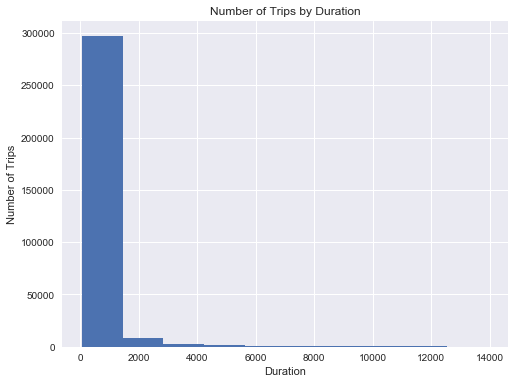

In [194]:
data_plot(df_trip, 'Duration')

It looks pretty strange. Looking at the duration value on x-axis it can be seen that most of the rides are in the duration of less than 1650. Since all the rides are expected to be 30 minutes or less as there is an overage charges for longer rides in one single trip. It shows the span of duration mostly upto 1200 minutes which is equivalent to around 17 hours.
From the statistics that I got from the usage_stats, it was expected that some trips would be really long which brings the average value to be so much higher than the median.

To understand the data better, using the visualization function. Setting filters as a list of conditions for the data points. Limiting the Duration to be less than 60 minutes.

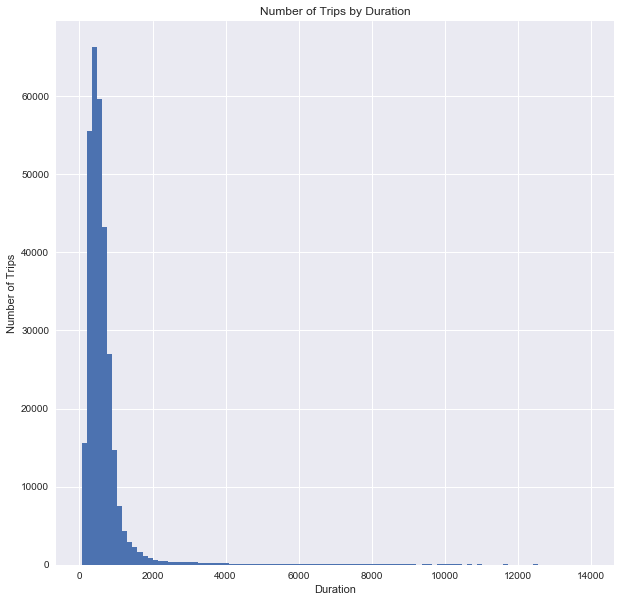

In [217]:
data_plot(df_trip, 'Duration', ['Duration < 60'])

This also does not give a lot of idea about the trip. To understand it better, plotting the graph for all the trips under 1600 minutes.

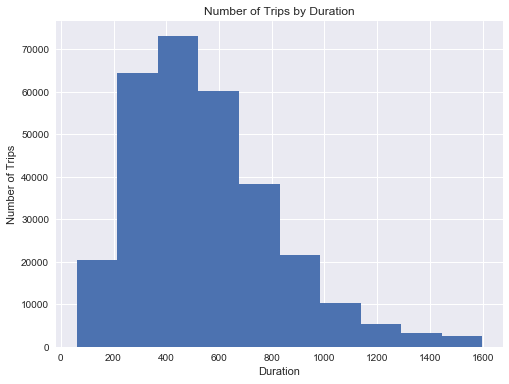

In [199]:
data_plot(df_trip, 'Duration', ['Duration < 1600'])

Yes, this looks better. It can be seen that most of the trips range in between 300-700 minutes in length. As it can be noted that none of the trips are for 0 minutes, the left side of the plot is above 0. So even that can be removed.
Also changing the bin widht to 100 for better visualization of the data.

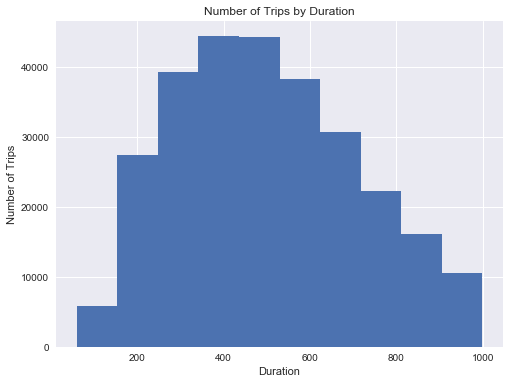

In [203]:
data_plot(df_trip, 'Duration', ['Duration < 1000'], boundary = 1, bin_width = 100)

It can be interpreted that the bin with 100 minutes has the most trip for the range 355 - 450 minutes, whicn represents aproximately 40000 trips made for this time duration.
To understand the data better, the bin width and few other filters can be changed to understand different scenarios of the data.

### Conclusion 
From this analysis, it can be concluded that 
1. The total number of trips in the Bay Area for the year 2015-2016 were 312121 and the average duration of trips was 698.95 minutes.
2.  25% of trips are shorter than 353.00 minutes.
3. 25% of trips are longer than 731.00 minutes.
4. From the graphs, it is seen that the maximum trips took place between 350-450 minutes which justifies with the shorter and longer rides that took place. 

# Analysis 4

Using the second argument of the function usage_stats() to count up the trips across a selected variable called Subscription_Type , to display the information in the plot. This plot shows the number of trips made by the customers and how many were made by the subscribers.

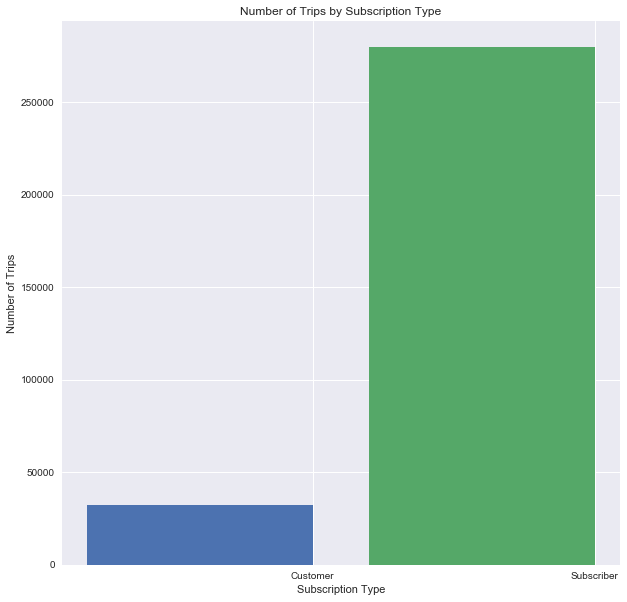

In [200]:
data_plot(df_trip, 'Subscription_Type')

It can be inferred that around 10% of the total trips were made by Customers and the remaining 90% were made by the Subscribers.
Customers made around 30000 trips where as the subscribers made around 280000 which is equivalent to the total number of trips that is 312121.

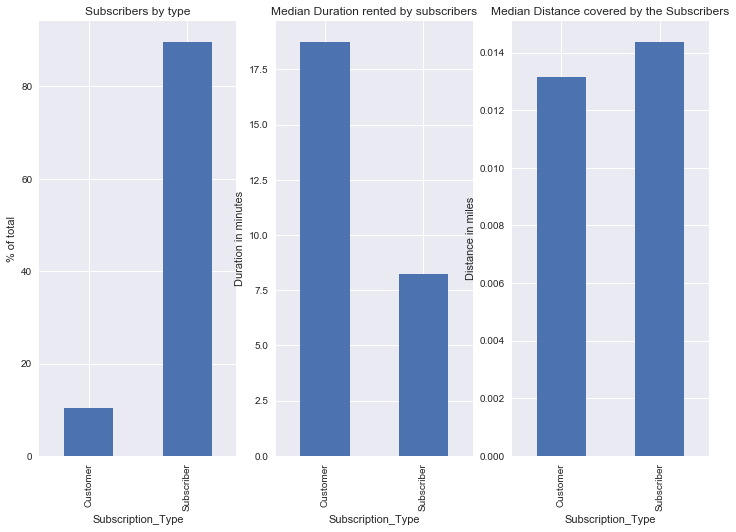

In [201]:
# To get a better understanding of the trends of customer and subscribers. 

subscrib_dur = df_trip.groupby('Subscription_Type')['Duration'].median()/60
dur_count = df_trip.groupby('Subscription_Type')['Duration'].count()
subscrip_dis = df_trip.groupby('Subscription_Type')['Distance'].median()/60

fig,axes = plt.subplots(figsize=(12, 8), nrows=1, ncols=3)
plt.sca(axes[0])
dur_count = dur_count/np.sum(dur_count.values)*100
dur_count.plot(kind = 'bar')
plt.ylabel('% of total')
plt.title('Subscribers by type')
plt.sca(axes[1])
subscrib_dur.plot(kind = 'bar')
plt.ylabel('Duration in minutes')
plt.title('Median Duration rented by subscriptions')
plt.sca(axes[2])
subscrip_dis.plot(kind = 'bar')
plt.ylabel('Distance in miles')
plt.title('Median Distance covered by the subscriptions')

Perfect. This gives the a very good picture of the spread of customers and subscribers in the dataset.
As seen in the graphs above it can be said that customers are 10% of the total riders. 
From how it should have been, the customers having a high median duration of rentals compared to that of subscribers.


### Conclusion
It can be concluded that,
1. The duration  and the median distance travelled for the customers is twice as that of the subscribers.
2. The 90% of the total trips are made by the Subscribers and the 10% were made by the customers.

# Analysis 5

Now that I know the trips made between the different subscription types and different places where the trips happened, I would want to know about the overtime fees and the traffic during the hour of the day.

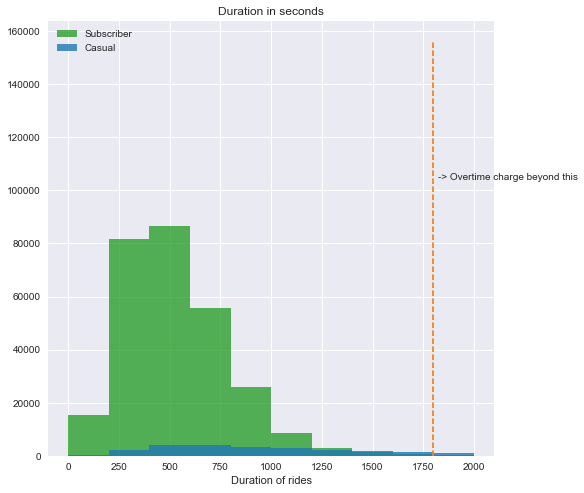

In [239]:
#Plot to see the duration of rides for the different subscription type and their overtime.
plt.figure(figsize = [8,8])
h = plt.hist(df_trip[df_trip['Subscription_Type'] == 'Subscriber']['Duration'].values,\
             range = [0,2000],color = colorcode[2],alpha = .8, label = 'Subscriber')

plt.plot([1800,1800],[0,float(df_trip.shape[0]/2)],color = colorcode[1],linestyle = '--')
plt.text(1820,float(df_trip.shape[0]/3),'-> Overtime charge beyond this')

h = plt.hist(df_trip[df_trip['Subscription_Type'] == 'Customer']['Duration'].values,\
             range = [0,2000],color = colorcode[0],alpha = .8, label = 'Casual')
plt.title('Duration in seconds')
plt.xlabel('Duration of rides')
plt.legend()

The plot shows the trend of trips made by the subscribers and the customers. Also,from the plot it can be seen that that mostly customers are the ones who pays the overtime fee. 

In [248]:
# To calculate the overtime fee paid by the subscribers and the customers
overtime = df_trip[(df_trip['Subscription_Type'] == 'Customer') & (df_trip['Duration']>1800)]['Duration'].count()/\
    float(df_trip[(df_trip['Subscription_Type'] == 'Customer')]['Duration'].count())
print("Overtime fee paid by the customers = {0}% ".format(np.round(overtime*100,0)))

overtime = df_trip[(df_trip['Subscription_Type'] == 'Subscriber') & (df_trip['Duration']>1800)]['Duration'].count()/\
    float(df_trip[(df_trip['Subscription_Type'] == 'Subscriber')]['Duration'].count())
print("Overtime fee paid by the subscribers = {0}%".format(np.round(overtime*100,0)))

Overtime fee paid by the customers = 29.0% 
Overtime fee paid by the subscribers = 0.0%


It tells us the exact over time feee paid by the subscribers and the customers. 29% of customers pay an overtime fee and very negligible amount of subscribers would pay the overtime fee. 
This alos matches from the graph plotted above which gives us a very good visualiztion of customers paying overtime fee.

In [249]:
# Days of the week
days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

Peak hour for Day 0 happens at 800 hours
Peak hour for Day 1 happens at 800 hours
Peak hour for Day 2 happens at 800 hours
Peak hour for Day 3 happens at 800 hours
Peak hour for Day 4 happens at 800 hours
Peak hour for Day 5 happens at 1300 hours
Peak hour for Day 6 happens at 1400 hours
Peak hour for Day 0 happens at 1600 hours
Peak hour for Day 1 happens at 1600 hours
Peak hour for Day 2 happens at 1700 hours
Peak hour for Day 3 happens at 1700 hours
Peak hour for Day 4 happens at 1700 hours
Peak hour for Day 5 happens at 1300 hours
Peak hour for Day 6 happens at 1300 hours


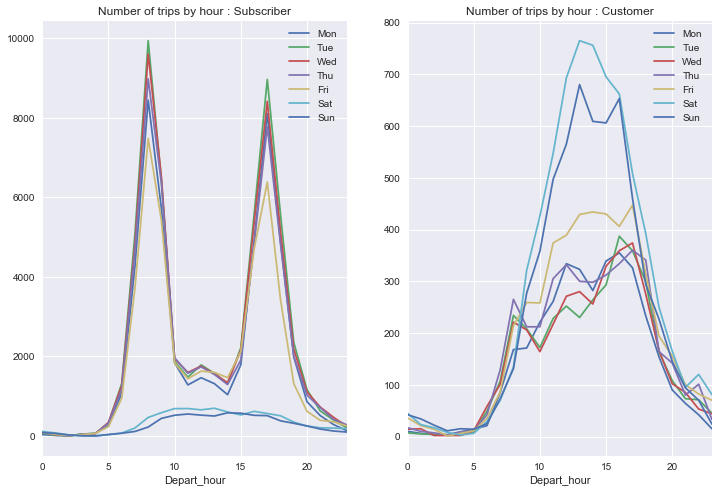

In [250]:
# Pattern between the subscribers and customers over the day of the week
fig,axes = plt.subplots(figsize=(12, 8), nrows=1, ncols=2)

a = df_trip[df_trip['Subscription_Type'] == 'Subscriber'].groupby(['WeekDays','Depart_hour'])['Trip_ID'].count()

plt.sca(axes[0])

for i in range(7):
    x = a[i].plot(label = days[i])
    print('Peak hour for Day {0} happens at {1}00 hours'.format(i,np.argmax(a[i])))
plt.title('Number of trips by hour : Subscriber')    
plt.legend()

a = df_trip[df_trip['Subscription_Type'] == 'Customer'].groupby(['WeekDays','Depart_hour'])['Trip_ID'].count()

plt.sca(axes[1])
for i in range(7):
    x = a[i].plot(label = days[i])
    print('Peak hour for Day {0} happens at {1}00 hours'.format(i,np.argmax(a[i])))
plt.title('Number of trips by hour : Customer')    
plt.legend()
plt.savefig("Pattern over the week")

We can see the trend of rides over the week for subscribers and customers as,
##Subscribers:
#Peak hour for Monday happens at 800 hours
#Peak hour for Tuesday happens at 800 hours
#Peak hour for Wednesday happens at 800 hours
#Peak hour for Thursday happens at 800 hours
#Peak hour for Friday happens at 800 hours
#Peak hour for Saturday happens at 1300 hours
#Peak hour for Sunday happens at 1400 hours
##Customers:
#Peak hour for Monday happens at 1600 hours
#Peak hour for Tuesday happens at 1600 hours
#Peak hour for Wednesday happens at 1700 hours
#Peak hour for Thursday happens at 1700 hours
#Peak hour for Friday happens at 1700 hours
#Peak hour for Saturday happens at 1300 hours
#Peak hour for Sunday happens at 1600 hours

#It can be seen that the weekday peak hours for Subscribers is in the morning at around 8 AM and for weekdays it is different
#Where as the weekday peek hours for cutomers is very random which shows that they are mostly tourists visiting the place.

#Also, the graph shows the traffic at every hour of the day for the entire week for both customers and subscribers.

### Conclusion

It can be concluded that,
1. 0% of subscribers pay overtime fee, whereas 26% of casual customers pay overtime fee.
2. Patterns between subscribers and casual customers over the course of the day is very different.

# To Summarize:

1. Top regions where there are bike rentals are Mountain View, Palo Alto, San Fransisco and San Jose, San Fransisco having the highest bike rentals pick ups and drops.
2. Traffic distribution for customers and subscribers between the loactions of different station terminals by taking in account their GPS location.
3. Data status which shows that total bike rentals that they get over the year is 312121 and the different stastitical analysis.
4. Distribution of customers and subscribers duration  and the median distance travelled to show that 90% of the total trips are made by the Subscribers and the 10% were made by the customers.
5. Patterns between subscribers and casual customers over the course of the day and the percentage of overtime fee that is paid by the customers.
